In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

df = pd.read_csv("~/Documents/Github/paper/input/df_3_years.csv")

X, y = df.drop(columns=['target_va']), df.target_va.values
X_train, X_test, y_train, y_test = train_test_split(X, y)

def score(model, X, y, cv=5, scoring='neg_root_mean_squared_error'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return abs(np.mean(scores)), np.std(scores)

## Baseline

In [2]:
y_preds = np.array(X.va_1.values)
np.sqrt(mean_squared_error(y_preds, y))

22.421478237960166

## Random forest

In [3]:
from sklearn.ensemble import RandomForestRegressor

#rf = RandomForestClassifier(random_state=42)
rf = RandomForestRegressor(max_depth=40, n_estimators=250, max_features=10,
                            min_samples_leaf=5, random_state=42)
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_})

rf.fit(X, y)
fi = rf_feat_importance(rf, X)
fi

,cols,imp
0,va_1,0.021953
1,irf_1,0.008292
2,srf_1,0.007840
3,va_2,0.055814
4,irf_2,0.009462
5,srf_2,0.018802
6,int_2,0.023125
7,va_3,0.167119
8,irf_3,0.009724
9,srf_3,0.009424


In [8]:
X.rename({'mean_vision': 'Mean VA', 
          'std_vision': 'SD VA',
          'va_4': 'Fourth VA'}, axis=1, inplace=True)
X

,va_1,irf_1,srf_1,va_2,irf_2,srf_2,int_2,va_3,irf_3,srf_3,int_3,Fourth VA,irf_4,srf_4,int_4,Mean VA,SD VA
0,89.0,0.000,0.000,85.0,0.000,0.000,24,85.0,0.000,0.000,27,94.0,0.000,0.000,22,88.25,3.624980
1,80.0,0.000,0.000,76.0,0.000,0.000,24,50.0,0.000,0.000,27,46.0,0.000,0.000,22,63.00,8.558216
2,55.0,0.000,38.260,70.0,0.000,38.260,29,76.0,0.000,38.260,28,70.0,0.000,38.260,28,67.75,4.446186
3,80.0,0.000,119.799,85.0,0.000,119.799,36,85.0,0.000,119.799,42,89.0,0.000,119.799,56,84.75,3.180237
4,76.0,0.000,17.622,65.0,0.000,17.622,36,65.0,0.000,17.622,42,65.0,0.000,17.622,56,67.75,12.222955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,70.0,0.000,0.000,80.0,0.000,0.000,16,76.0,0.000,0.000,120,85.0,0.000,0.000,252,77.75,4.561311
385,70.0,0.000,0.000,76.0,0.000,0.000,16,76.0,0.000,0.000,120,76.0,0.000,0.000,252,74.50,2.924988
386,65.0,81.362,33.794,76.0,81.362,33.794,46,76.0,81.362,33.794,57,61.0,81.362,33.794,77,69.50,5.007261
387,80.0,0.000,0.000,76.0,0.000,0.000,42,76.0,0.000,0.000,27,80.0,0.000,0.000,42,78.00,1.959592


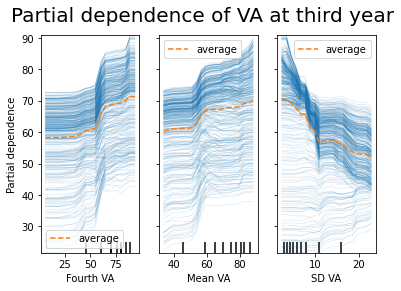

In [10]:
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay

features = ['Fourth VA', 'Mean VA', 'SD VA']

display = PartialDependenceDisplay.from_estimator(
    rf,
    X,
    features,
    kind="both",
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
display.figure_.suptitle(
    "Partial dependence of VA at third year", size=20
)
display.figure_.subplots_adjust(hspace=0.3)
display.figure_.savefig("partial_dependence.png", dpi=250)

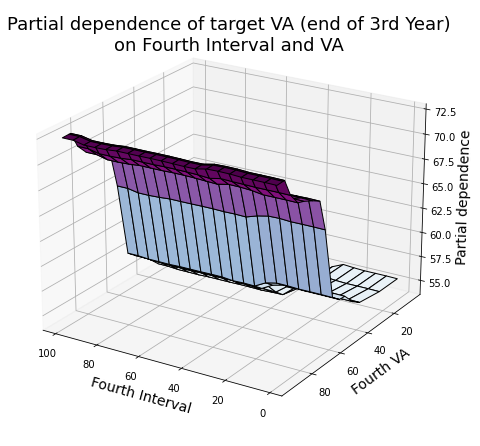

In [44]:
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))

features = ('int_4', 'va_4')
pdp, axes = partial_dependence(rf, X, features=features,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel("Fourth Interval", size=14)
ax.set_ylabel("Fourth VA", size=14)
ax.set_zlabel('Partial dependence', size=14)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
#  pretty init view
ax.view_init(elev=22, azim=122)
#plt.colorbar(surf)
plt.suptitle('Partial dependence of target VA (end of 3rd Year)\n'
             'on Fourth Interval and VA', size=18)
plt.subplots_adjust(top=0.9)
plt.savefig("3d_partial_dep.png", dpi=300)
plt.show()

In [45]:
# regression task - fourth interval 

## Ensemble

In [14]:
estimators = [('lr', LinearRegression()), ('gb', GradientBoostingRegressor(random_state=42))]
reg = StackingRegressor(estimators=estimators,
                        final_estimator=RandomForestRegressor(n_estimators=10, random_state=42))
reg.fit(X_train, y_train)
y_preds = reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_preds))

15.630479855404442

In [15]:
score(reg, X, y)

(17.139633636594287, 2.022700187928369)

## MLP

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(18, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(18)
        self.batchnorm2 = nn.BatchNorm1d(32)
    
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(self.batchnorm1(x))))
        x = self.dropout(torch.relu(self.fc2(self.batchnorm2(x))))    
        output = self.out(x)
        return output

In [132]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=4, padding=2)
        self.conv2 = nn.Conv1d(in_channels=5, out_channels=2, kernel_size=4, padding=2)
        self.layer1 = nn.Sequential(self.conv1, nn.ReLU())
        self.layer2 = nn.Sequential(self.conv2, nn.ReLU())         
        # fully connected layer, output 2 classes
        self.layer3 = nn.Sequential(nn.Linear(32, 64), nn.ReLU(),
                                    nn.Linear(64, 16), nn.ReLU(),
                                    nn.Linear(16, 8), nn.ReLU())
        self.out = nn.Linear(8, 1)
    
    def forward(self, x):
        x = self.layer1(x.unsqueeze(1))
        x = self.layer2(x)
        # flatten the output of conv2 to (batch_size, 32)
        x = x.view(x.size(0), -1) 
        x = self.layer3(x)
        output = self.out(x)
        return output

In [25]:
class PytorchKfolds:
    
    def __init__(self, n_epochs=30):
        self.df = pd.read_csv("~/Documents/Github/paper/input/df_3_years.csv")
        self.kdf = self.create_folds(self.df)
        self.n_epochs = n_epochs
        self.loss_fn = nn.MSELoss()
    
    def create_folds(self, df):
        # we create a new column called kfold and fill it with -1
        df["kfold"] = -1
        # the next step is to randomize the rows of the data
        df = df.sample(frac=1).reset_index(drop=True)
        # fetch labels
        y = df.target_va.values
        # initiate the kfold class from model_selection module
        kf = model_selection.KFold(n_splits=5)
        # fill the new kfold column
        for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
            df.loc[v_, 'kfold'] = f
        return df
    
    def inputs_targets(self, df, fold):
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_train.fillna(df_train.mean(), inplace=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)
        df_valid.fillna(df_valid.mean(), inplace=True)
        X_train = df_train.drop(columns=["target_va", "kfold"]).values
        y_train = df_train.target_va.values
        X_valid = df_valid.drop(columns=["target_va", "kfold"]).values
        y_valid = df_valid.target_va.values
        return X_train, X_valid, y_train, y_valid
    
    def train_test_kfold(self, df, fold):
        X_train, X_test, y_train, y_test = self.inputs_targets(df, fold)
        # scale the data
        ss = StandardScaler()
        mm = MinMaxScaler()
        X_train, X_test = ss.fit_transform(X_train), ss.fit_transform(X_test)
        y_train = mm.fit_transform(y_train.reshape(-1, 1))
        y_test = mm.fit_transform(y_test.reshape(-1, 1))
        # convert to tensors
        X_train_tensors = Variable(torch.Tensor(X_train))
        X_test_tensors = Variable(torch.Tensor(X_test))
        y_train_tensors = Variable(torch.Tensor(y_train))
        y_test_tensors = Variable(torch.Tensor(y_test))
        return X_train_tensors, X_test_tensors, y_train_tensors, y_test_tensors
    
    def create_dataloaders(self, X_train, X_test, y_train, y_test):
        train_data, test_data = [], []
        for i in range(len(X_train)):
            train_data.append([X_train[i].to(torch.float32), 
                               y_train[i].type(torch.float32)])
        for i in range(len(X_test)):
            test_data.append([X_test[i].to(torch.float32), 
                               y_test[i].type(torch.float32)])
        train_loader = torch.utils.data.DataLoader(train_data, shuffle=False, 
                                               batch_size=64, drop_last=True)
        test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, 
                                                  batch_size=len(X_test))
        return train_loader, test_loader
    
    def reset_weights(self, m):
        for layer in m.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        
    def rmse_score(self, val_loader, model):
        model.eval()
        rmses = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                outputs = model(imgs).detach().numpy()
                labels = labels.detach().numpy()
                rmse = np.sqrt(mean_squared_error(outputs, labels))
                rmses.append(rmse)
            return np.round(np.mean(rmses), 4)
                
    
    def training_loop(self, train_loader, val_loader, verbose=0):
        n_epochs=self.n_epochs
        model=Net()
        model.apply(self.reset_weights)
        optimiser=torch.optim.Adam(model.parameters(), lr=1e-2)
        loss_fn=self.loss_fn
        model.train()
        count, best_rmse = 0, 1000
        for epoch in range(1, n_epochs + 1):
            loss_train, loss_test = 0.0, 0.0
            for imgs, labels in train_loader:
                b_x = Variable(imgs)   # batch x
                b_y = Variable(labels)   # batch y
                outputs = model(imgs)
                loss = loss_fn(outputs, b_y)
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
                loss_train += loss.item() # .item() is used to escape gradient
            rmse = 100*self.rmse_score(val_loader, model)
            # early stopping
            if (best_rmse < rmse) and count > 40: 
                print("EARLY STOPPING INITIATED.")
                print(f"Best RMSE = {best_rmse}. Epoch = {epoch}.")
                break
            else: 
                if best_rmse > rmse: best_rmse = rmse
                count += 1
            if (epoch == 1 or epoch % (n_epochs/10) == 0) and verbose>1:
                print("Epoch {}, Training Loss {}, RMSE {}%".format(
                    epoch,
                    np.round(loss_train / len(train_loader), 4),
                    np.round(rmse, 2)))
        test_rmse = 100*self.rmse_score(val_loader, model)
        if verbose==1: print(f"Test RMSE = {test_rmse}")
        return test_rmse
                
    def kfold_train(self, verbose=0):
        rmses = []
        for i in range(5):
            if verbose > 0: print(f'FOLD {i}')
            X_train, X_test, y_train, y_test = self.train_test_kfold(self.kdf, i)
            train_loader, val_loader = self.create_dataloaders(X_train, X_test, y_train, y_test)
            test_rmse = self.training_loop(train_loader=train_loader,
                                           val_loader=val_loader, verbose=verbose)
            rmses.append(np.round(test_rmse, 2))
            if verbose > 0: print('--------------------------------')
        if verbose!=-1:
            print("FINAL RESULTS")
            print(f"Mean validation RMSE: {round(np.mean(rmses), 2)} (+/- {round(np.std(rmses), 2)})")
        if verbose==-1: return np.mean(rmses)

In [26]:
ete = PytorchKfolds(n_epochs=2000)
ete.kfold_train(verbose=1)

FOLD 0
EARLY STOPPING INITIATED.
Best RMSE = 17.329999804496765. Epoch = 42.
Test RMSE = 18.050000071525574
--------------------------------
FOLD 1
EARLY STOPPING INITIATED.
Best RMSE = 16.64000004529953. Epoch = 42.
Test RMSE = 19.930000603199005
--------------------------------
FOLD 2
EARLY STOPPING INITIATED.
Best RMSE = 17.339999973773956. Epoch = 42.
Test RMSE = 20.640000700950623
--------------------------------
FOLD 3
EARLY STOPPING INITIATED.
Best RMSE = 18.770000338554382. Epoch = 42.
Test RMSE = 21.02999985218048
--------------------------------
FOLD 4
EARLY STOPPING INITIATED.
Best RMSE = 16.189999878406525. Epoch = 42.
Test RMSE = 17.45000034570694
--------------------------------
FINAL RESULTS
Mean validation RMSE: 19.42 (+/- 1.42)


In [144]:
def epoch_search(start, stop, step):
    best_rmse, best_epoch = 0.0, 0
    for i in range(start, stop, step):
        ete = PytorchKfolds(n_epochs=i)
        rmse = ete.kfold_train(verbose=-1)
        if rmse > best_rmse:
            best_rmse = rmse
            best_epoch = i
    return best_rmse, best_epoch

## TabNet

In [4]:
from pytorch_tabnet.tab_model import TabNetRegressor
import sklearn

df = pd.read_csv("~/Documents/Github/paper/input/df_3_years.csv")

X, y = df.drop(columns=['target_va']).values, df.target_va.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "verbose":0,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetRegressor(**tabnet_params) 
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)],
        eval_metric=['rmse'], patience=100,
        max_epochs=1000)


Early stopping occurred at epoch 387 with best_epoch = 287 and best_val_0_rmse = 13.84754
Best weights from best epoch are automatically used!


In [5]:
preds = clf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

13.84753716554082

In [6]:
clf.feature_importances_

array([0.00707996, 0.02121584, 0.029462  , 0.24704875, 0.03907303,
       0.0395175 , 0.00631141, 0.01805274, 0.07496803, 0.00124507,
       0.0726348 , 0.16217724, 0.01825936, 0.01906842, 0.06029381,
       0.04118198, 0.14241006])